In [1]:
import polars as pl
pl.Config.set_tbl_width_chars(64)
pl.Config.set_fmt_str_lengths(64)

polars.config.Config

In [2]:
df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_born.ipc")

In [9]:
df.schema

{'unit_tag_index': UInt32,
 'unit_tag_recycle': UInt32,
 'unit_type_name': Utf8,
 'control_player_id': UInt8,
 'upkeep_player_id': UInt8,
 'x': UInt8,
 'y': UInt8,
 'creator_unit_tag_index': UInt32,
 'creator_unit_tag_recycle': UInt32,
 'creator_ability_name': Utf8,
 'ext_replay_loop': Int64,
 'ext_replay_seconds': UInt32,
 'ext_fs_replay_file_name': Utf8,
 'ext_fs_replay_sha256': Utf8,
 'ext_replay_detail_player_name': Utf8,
 'ext_replay_detail_datetime': Datetime(time_unit='ns', time_zone=None)}

In [22]:
unit_frequency = df.group_by("unit_type_name").agg(
    pl.count()
).filter(
    (pl.col("count") > 1000) &
    (pl.col("unit_type_name") != "InvisibleTargetDummy") &
    (~pl.col("unit_type_name").str.starts_with("Beacon")) &
    (~pl.col("unit_type_name").str.ends_with("Geyser")) &
    (~pl.col("unit_type_name").str.starts_with("LabMineralField")) &
    (~pl.col("unit_type_name").str.starts_with("RichMineralField")) &
    (~pl.col("unit_type_name").str.starts_with("MineralField"))
).collect().sort("count",descending=True)
unit_frequency

unit_type_name,count
str,u32
"""Larva""",1572841
"""Broodling""",754528
"""Drone""",638424
"""BroodlingEscort""",622023
"""Zergling""",465616
"""SCV""",252903
"""Probe""",250425
"""Marine""",186063
"""Hydralisk""",166593


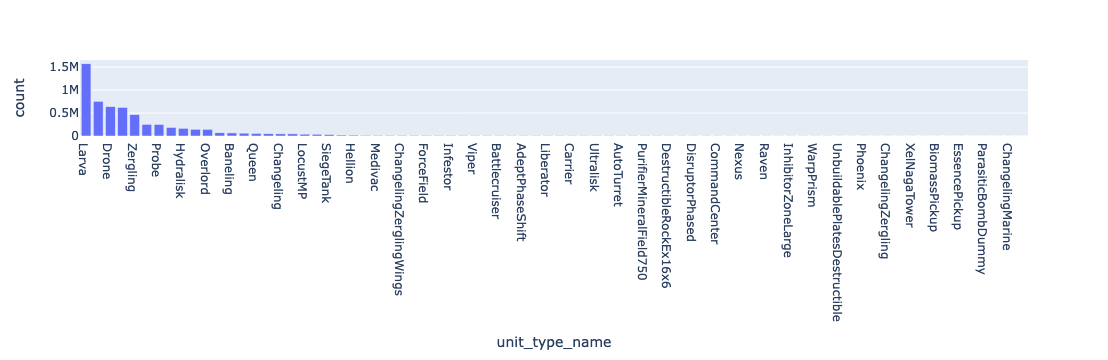

In [23]:
import plotly.express as px
fig = px.bar(unit_frequency, x='unit_type_name', y='count')
fig.show()

In [61]:
drone_birth = df.select([
    "ext_replay_detail_datetime", "unit_type_name", "ext_replay_seconds", "ext_replay_detail_player_name"
]).filter(
    (pl.col("unit_type_name") == "Drone") &
    (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed") &
    (pl.col("ext_replay_seconds") < 120)
).collect().group_by([pl.count().alias("drone_born_count")]).sort("ext_replay_detail_datetime").with_columns([
    pl.col("ext_replay_detail_datetime").set_sorted(),
    pl.col("drone_born_count")
]).group_by_rolling(index_column="ext_replay_detail_datetime", period="1w", check_sorted=False).agg([
    pl.count().alias("born_drone_count")
])
drone_birth

AttributeError: 'GroupBy' object has no attribute 'sort'

/home/seb/git/polars/venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



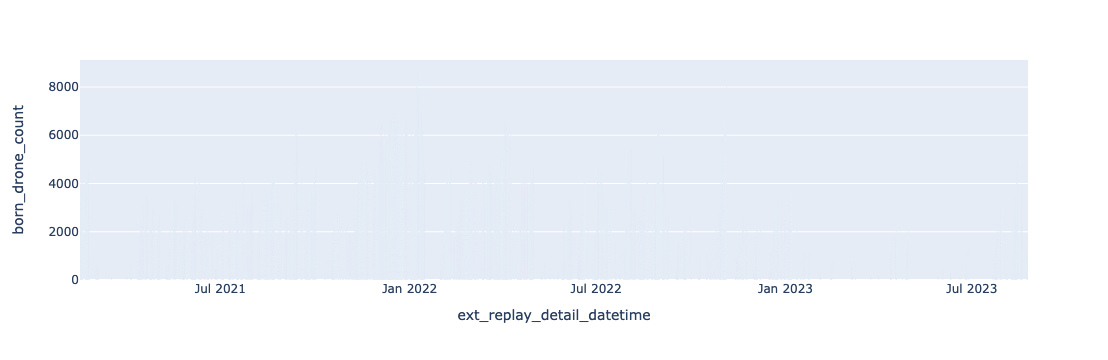

In [57]:
import plotly.express as px
fig = px.bar(drone_birth, x='unit_type_name', y='count')
fig.show()